# Binary classification

## Introduction

In this notebook, we will perform binary classification analysis using LLMs. Binary classification refers to the task of categorizing data entries into one of two predefined categories. 

### Dataset Description

### Dataset Structure

## Import the libraries

In [1]:
import os
import pandas as pd
from qualitative_analysis import (
    load_data,
    clean_and_normalize,
    sanitize_dataframe,
    get_llm_client,
    compute_all_kappas,
    plot_confusion_matrices,
    process_verbatims_for_binary_criteria,  # Additional import if you want to save the results of the classification as a csv
)
import qualitative_analysis.config as config

## Load the data

In [2]:
# Define data directory
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# Define the path to your dataset
data_file_path = os.path.join(data_dir, "multiclass_sample.csv")

# Load the data
data = load_data(data_file_path, file_type="csv", delimiter=";")

# Preview the data
data.head()

,q_index,text,question,div_rater1,div_rater2,div_rater3
0,196,Les énormes yeux des insectes font quasiment l...,Pourquoi ces petits yeux sont chargés de trait...,2,2,2
1,197,Les énormes yeux des insectes font quasiment l...,Comment les point sont ensuite assemblés,2,2,0
2,198,Les énormes yeux des insectes font quasiment l...,C'est quoi un casque de vision 3D ?,2,2,2
3,199,Les énormes yeux des insectes font quasiment l...,Combien d'yeux petits ont les humains en moyen...,2,2,2
4,200,Les énormes yeux des insectes font quasiment l...,Quel être vivant a le plus de petis yeux ?,1,1,2


## Data Preprocessing

In [3]:
# 1a) Define a mapping from old column names to new names
# rename_map = {
#     "ref": "reference",
#     "txt1.ctrl1": "Identify",
#     "txt1.det": "Guess",
#     "txt1.exp": "Seek",
#     "txt1.ctrl2": "Assess"
# }

# # 1b) Rename the columns in the DataFrame
# data = data.rename(columns=rename_map)

# 2) Now define the new column names for cleaning
text_columns = ["text", "question"]

# 3) Clean and normalize the new columns
for col in text_columns:
    data[col] = clean_and_normalize(data[col])

# 4) Sanitize the DataFrame
data = sanitize_dataframe(data)

## Combine Texts and Questions

In [4]:
# Combine texts and entries

data["verbatim"] = data.apply(
    lambda row: (f"Texte: {row['text']}\n\n" f"Question: {row['question']}"), axis=1
)

# Extract the list of verbatims
verbatims = data["verbatim"].tolist()

print(f"Total number of verbatims: {len(verbatims)}")
print(f"Verbatim example:\n{verbatims[0]}")

Total number of verbatims: 107
Verbatim example:
Texte: Les enormes yeux des insectes font quasiment le tour de leurs tetes. Ils voient donc en meme temps vers lavant, vers larriere, a droite, a gauche, vers le haut et vers le bas. Encore mieux quun casque de vision en 3D! En revanche, ils ne voient pas tres net, parce que leur il est constitue de centaines, ou meme de milliers de petits yeux simples. Chacun de ces petits yeux est charge de traiter une toute petite partie de lenvironnement. Un petit il produit un simple point dune teinte et dune intensite lumineuse donnees. Ces points sont ensuite assembles les uns aux autres dans le cerveau de linsecte pour former une image complete et unique. Un il dune abeille contient 4500 petits yeux. Celui dune libellule en a 15000: cest l'il le plus complexe chez les insectes !

Question: Pourquoi ces petits yeux sont charges de traiter une petite partie de l'environnement ?


## Choose the LLM

In [5]:
# Choose the provider and model
provider = "azure"
model_name = "gpt-4o-mini"

# Initialize the client
llm_client = get_llm_client(provider=provider, config=config.MODEL_CONFIG[provider])

## Prompt Construction and Classification

In [6]:
# Define instructions for multiclass classification
# Classification settings
reasoning = True  # If True, perform two-step reasoning. If False, single-step classification.
verbose = True # If True, show the prompt

# Select subset of verbatims for testing
subset = 5
verbatims_subset = verbatims[:subset]

codebook = {
"Classification de divergence": 
    """
    Codebook :

    Les données se composent d'un texte de référence et d'une question posée par un enfant.
    Vous devez classer la question dans l'une des catégories suivantes :

    0 : la réponse à la question est indiquée dans le texte.
    1 : la réponse à la question n'est pas du tout indiquée dans le texte.

    Les erreurs mineures d'orthographe, de grammaire ou de formulation ne doivent pas être pénalisées tant que l'intention de l'entrée est claire et respecte les critères d'inclusion. Concentrez-vous sur le contenu et l'objectif de l'entrée plutôt que sur la perfection linguistique.

    Exemples :

    Exemple 1
    Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
    Question: Quand est-elle née ?
    Réponse: 1

    Exemple 2
    Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
    Question: Marie a-t-elle passé toute sa vie en Pologne ?
    Réponse: 0

    Exemple 3
    Texte: Marie Curie est née en Pologne. Elle fait ses études à la faculté des sciences de Paris. Elle fait partie des rares femmes qui y sont admises. Avec son mari Pierre Curie, ils travaillent sur l’étude des rayons X et découvrent deux éléments radioactifs. Le couple reçoit le prix Nobel de physique pour ça. Pendant la Première Guerre mondiale, Marie met en place des ambulances équipées d’appareils de radiologie, ce qui permet de sauver de nombreux blessés. Marie Curie est la première femme à avoir reçu deux prix Nobel: un avec Pierre Curie en physique, et l’autre pour ses recherches en chimie. Elle est morte en 1934.
    Question: Qui est Pierre Curie ?
    Réponse: 1
    """
}

# Define column descriptions
column_descriptions = (
    "Texte: Le texte de référence\n"
    "Question: La question de l'enfant."
)

# Define queries for multiclass classification and reasoning
binary_query = "Ne répondez qu'avec le chiffre de classification, rien d'autre"
reasoning_query = "Générez un raisonnement d'une seule phrase à propos de la classification (ne donnez pas le label de classification)." # used only if reasoning = True

# To be sure to have an integer only when doing 1 call request
command = (
    "Ne répondez qu'avec le chiffre de classification, rien d'autre. Les erreurs mineures d'orthographe, de grammaire ou de formulation ne doivent pas être pénalisées tant que l'intention de l'entrée est claire et respecte les critères d'inclusion. Concentrez-vous sur le contenu et l'objectif de l'entrée plutôt que sur la perfection linguistique."
    if not reasoning
    else "Les erreurs mineures d'orthographe, de grammaire ou de formulation ne doivent pas être pénalisées tant que l'intention de l'entrée est claire et respecte les critères d'inclusion. Concentrez-vous sur le contenu et l'objectif de l'entrée plutôt que sur la perfection linguistique."
)

prompt_template = f"""
Entrée:
{{verbatim_text}}

Vous devez l'évaluer de la sorte :
{{codebook}}

Les données sont au format suivant :
{column_descriptions}

{command}
"""

results_binary, verbatim_costs_binary = process_verbatims_for_binary_criteria(
    verbatims_subset=verbatims_subset,
    codebooks=codebook,
    llm_client=llm_client,
    model_name=model_name,
    prompt_template=prompt_template,
    reasoning_query=reasoning_query,
    binary_query=binary_query,
    reasoning=reasoning,
    verbose=verbose
)

for result in results_binary:
    print(result)

results_df = pd.DataFrame(results_binary)


=== Processing Verbatim 1/5 ===

--- Evaluating Theme: Classification de divergence ---
Prompt:

Entrée:
Texte: Les enormes yeux des insectes font quasiment le tour de leurs tetes. Ils voient donc en meme temps vers lavant, vers larriere, a droite, a gauche, vers le haut et vers le bas. Encore mieux quun casque de vision en 3D! En revanche, ils ne voient pas tres net, parce que leur il est constitue de centaines, ou meme de milliers de petits yeux simples. Chacun de ces petits yeux est charge de traiter une toute petite partie de lenvironnement. Un petit il produit un simple point dune teinte et dune intensite lumineuse donnees. Ces points sont ensuite assembles les uns aux autres dans le cerveau de linsecte pour former une image complete et unique. Un il dune abeille contient 4500 petits yeux. Celui dune libellule en a 15000: cest l'il le plus complexe chez les insectes !

Question: Pourquoi ces petits yeux sont charges de traiter une petite partie de l'environnement ?

Vous devez l'

## Saving the Results

This step provides an option to save the classification results to a file for future reference or further analysis.

In [7]:
# Possibility to save the results

# # Define the save path
# outputs_dir = os.path.join(data_dir, 'outputs')
# os.makedirs(outputs_dir, exist_ok=True)
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# save_path = os.path.join(outputs_dir, f"experiment_{model_name.replace('/', '_')}_{timestamp}.csv")

# # Save results
# save_results_to_csv(
#     coding=results_df.to_dict('records'),
#     save_path=save_path,
#     fieldnames=['Verbatim', 'Label'],
#     verbatims=None  # Verbatims are included in the results
# )

## Evaluating Model Performance Against Human Annotations

### Computing Cohen's Kappa

In this step, we compare the model's classifications with human annotations using Cohen's Kappa.

1. **Unweighted Kappa**:  
   All disagreements are treated equally, regardless of the "distance" between the categories. For example, a mismatch between `0` and `1` is penalized the same as a mismatch between `0` and `2`.

2. **Linear Weights**:  
   With `weights='linear'`, disagreements are penalized proportionally to their distance. For instance:
   - A mismatch between `0` and `1` incurs a smaller penalty than a mismatch between `0` and `2`.
   - This approach is suitable when the categories have a natural ordering (e.g., `0 < 1 < 2`) but the differences are not exponential.

3. **Quadratic Weights**:  
   With `weights='quadratic'`, disagreements are penalized more heavily as the distance increases. This approach emphasizes larger disagreements even more than linear weights.



In [8]:
# Assuming you have human annotations in the data
model_coding = results_df["Label"].tolist()
model_coding = [int(x) for x in model_coding]

human_annotations = {
    "div_rater1": [int(x) for x in data["div_rater1"].tolist()],
    "div_rater2": [int(x) for x in data["div_rater2"].tolist()],
    "div_rater3": [int(x) for x in data["div_rater3"].tolist()],
}

# Shorten data for demonstration if needed
model_coding_short = model_coding[:subset]
human_annotations_short = {
    rater: ann[:subset] for rater, ann in human_annotations.items()
}

# Compute Cohen's Kappa for all pairings and print results
kappa_results = compute_all_kappas(
    model_coding_short,
    human_annotations_short,
    labels=[0, 1, 2],
    weights="linear",
    verbose=True,
)

Model vs div_rater1: 0.00
Model vs div_rater2: 0.00
Model vs div_rater3: -0.07
div_rater1 vs div_rater2: 1.00
div_rater1 vs div_rater3: -0.15
div_rater2 vs div_rater3: -0.15


### Visualizing Agreement

In this step, we plot confusion matrices to visualize the agreement between the model's classifications and human annotations, or between two human annotations.

**Inputs**:
- `model_coding_short`: The model's predictions for the subset of data.
- `human_annotations_short`: The annotations from human raters for the same subset.

**Labels**:
- `[0, 1, 2]`: The three classification categories representing:
   - `0`: The answer is explicitly in the text.
   - `1`: The answer can be inferred from the text.
   - `2`: The answer is not in the text at all.


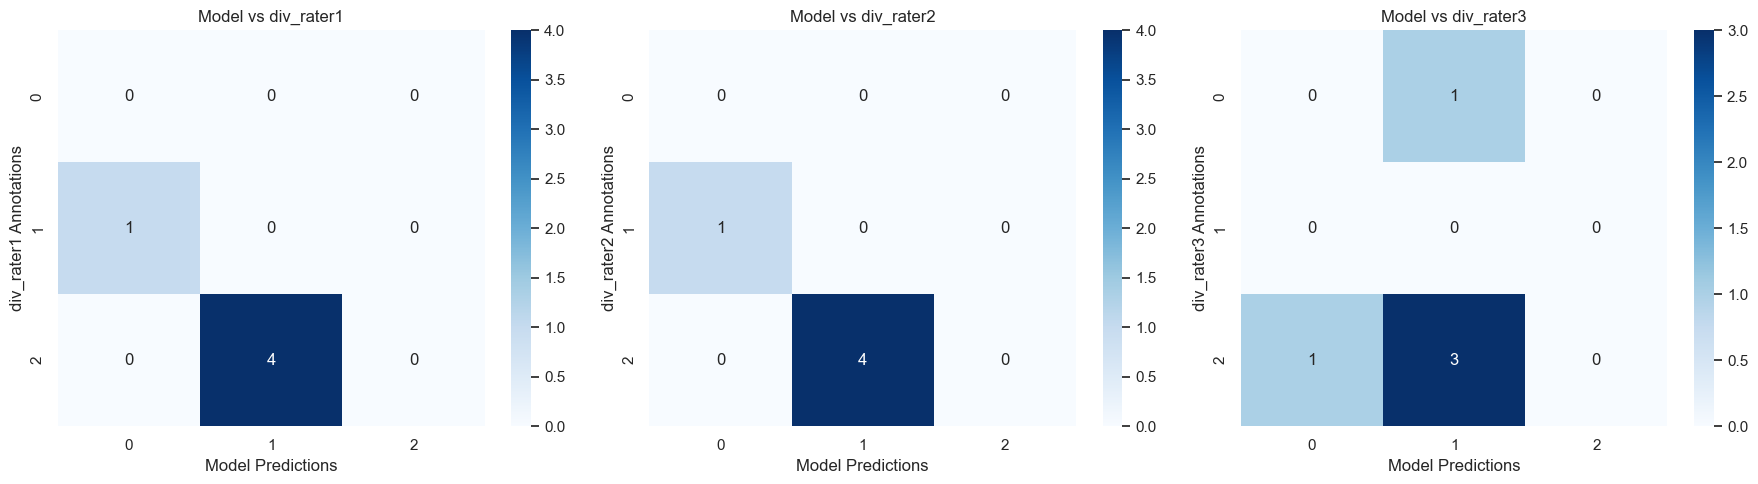

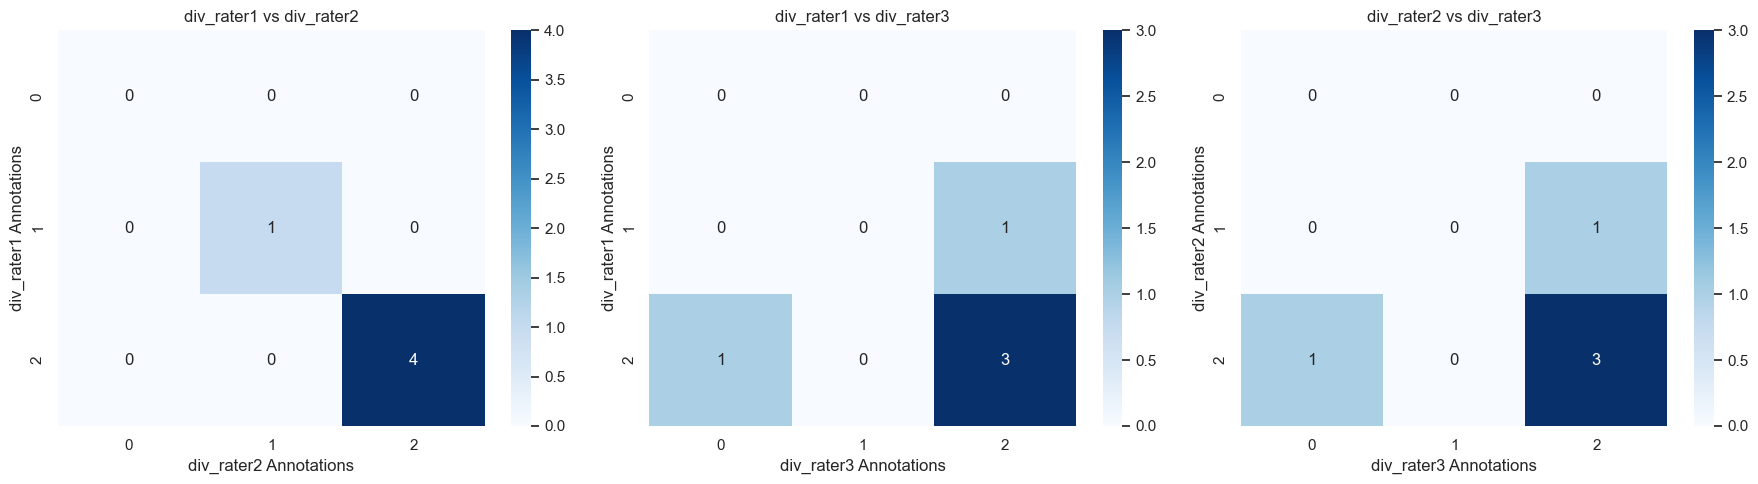

In [9]:
# Plot confusion matrices for all comparisons
plot_confusion_matrices(model_coding_short, human_annotations_short, labels=[0, 1, 2])

In [10]:
# def generate_embedding(row, llm_client, embedding_model="text-embedding-ada-002"):
#     """
#     Generates an embedding for a given row.

#     Parameters:
#         row (pd.Series): A row from the DataFrame.
#         llm_client (LLMClient): An instance of OpenAILLMClient.
#         embedding_model (str): The embedding model to use.

#     Returns:
#         list: The embedding vector.
#     """
#     # Construct the text to embed
#     text_to_embed = ''
#     for col in data.columns:
#         if col == 'question':
#             value = row[col]
#             text_to_embed += f"{col}: {value}\n"

#     # Fetch the embedding
#     embedding = llm_client.get_embedding(
#         input_text=text_to_embed,
#         model=embedding_model
#     )
#     return embedding

# import time

# # Initialize a list to store embeddings
# embeddings = []

# # Iterate over each row to generate embeddings
# for idx, row in data.iterrows():
#     embedding = generate_embedding(row, llm_client)
#     if embedding is not None:
#         embeddings.append(embedding)
#     else:
#         # Handle failed embedding generation
#         embeddings.append([None] * 1536)  # Assuming the embedding size is 1536 for text-embedding-ada-002
#     # Optional: Sleep to respect rate limits
#     time.sleep(0.1)  # Adjust based on your API rate limits


In [11]:
# # Add the embeddings as a new column in the DataFrame
# data['embedding'] = embeddings

In [12]:
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import seaborn as sns

In [13]:
# # Extract embeddings, ensuring there are no missing values
# valid_embeddings = data['embedding'].dropna()
# ids = data.loc[valid_embeddings.index, 'ID']

# # Convert to numpy array
# embeddings_array = np.vstack(valid_embeddings.values)
# # Initialize t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

# # Fit and transform embeddings
# reduced_embeddings = tsne.fit_transform(embeddings_array)
# # Create a DataFrame with reduced embeddings
# plot_df = pd.DataFrame({
#     'ID': ids,
#     'Dimension 1': reduced_embeddings[:, 0],
#     'Dimension 2': reduced_embeddings[:, 1]
# })

# # If you have labels, add them
# # Example: plot_df['Label'] = df.loc[valid_embeddings.index, 'predicted_label']
# plt.figure(figsize=(12, 8))
# sns.scatterplot(
#     data=plot_df,
#     x='Dimension 1',
#     y='Dimension 2',
#     # hue='Label',  # Uncomment if you have labels
#     palette='viridis',
#     s=50,
#     alpha=0.7
# )
# plt.title('2D Visualization of Embeddings using t-SNE')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# # plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')  # Uncomment if you have labels
# plt.tight_layout()
# plt.show()